# Adiabatic Cooling

Adiabatic energy changes are always happening when the advection field has a non-neglible divergence $\nabla \vec{u} \neq 0$.

The relevant term is is usually included in the transport equation as $\frac{\partial n}{\partial t} = \frac{p}{3} \,\nabla \vec{u} \frac{\partial n}{\partial p}$.

This module should always be included when advection is relevant. It can also be used to model acceleration of cosmic rays in a shock via adiabatic heating. In this case the SphericalAdvectionShock advection field is needed.

*Note*:
For AdiabaticCooling to work the used AdvectionField class needs to provide a getDivergence() method.

In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.optimize import curve_fit
import sys
sys.path.append('../../../../build/')
from crpropa import *

#figure settings
A4heigth = 29.7/2.54
A4width = 21./2.54
colors = sns.color_palette()

In [2]:
def fit(x, a, b):
    return a*x+b

## Example

Cosmic rays injected in a shell at $r=r_0$ and then advected radially outwards.

The number density $n(r)=\frac{N}{V(r)}=\frac{N}{4\pi r^2 \delta r}\propto \frac{1}{r^2}$

The energy density is $w(r)=\frac{E}{V(r)}$

From thermodynamics it is known that for an adiabatic process of an ideal gas:
* $PV = Nk_BT=E$
* $V^{\gamma-1}T = const.$

Therefore:
$w=\frac{N k_B T}{V}\propto \frac{n}{V^{\gamma-1}} \propto n n^{\gamma-1} = n^\gamma$

With $\gamma=4/3$ it is expected that the energy density drops with $w\propto n^{4/3}\propto r^{-8/3}$

In [3]:
N = 1000

# Number of Snapshots
# used in ObserverTimeEvolution
n = 100.
step = 100.*c_light


# magnetic field
# Remark:
# This will be neglected later by setting the diffusion coefficient to 0
# It is a work around for this demonstration as usually one needs advection 
# always in combination with diffusion.
ConstMagVec = Vector3d(0*nG,0*nG,1*nG)
BField = UniformMagneticField(ConstMagVec)

# AdvectionField
# Spherical advection field with constant divergence
AdvField = ConstantSphericalAdvectionField(Vector3d(0), 10*meter/second)

# parameters used for field line tracking
precision = 1e-4
minStep = 1e-4*c_light
maxStep = 1.*c_light

# source settings
# A point source at the origin is isotropically injecting 10TeV protons.
source = Source()
source.add(SourceUniformShell(Vector3d(0), 1e2))
#Important to use charged particles as neutral particles not be purly advective but remain their 
#rectilinear motion
source.add(SourceParticleType(nucleusId(1, 1)))
source.add(SourceEnergy(1*eV))
source.add(SourceIsotropicEmission()) #emission direction is irrelevant for DiffusionSDE module

# Output settings
# Only serial number, trajectory length and current position are stored
# The unit of length is set to kpc
Out = TextOutput('./Test3.txt')
Out.disableAll()
Out.enable(Output.TrajectoryLengthColumn)
Out.enable(Output.CurrentPositionColumn)
Out.enable(Output.CurrentEnergyColumn)
Out.setLengthScale(meter)
Out.setEnergyScale(100*eV)

# Observer settings
Obs = Observer()
Obs.add(ObserverTimeEvolution(step, step, n))
Obs.setDeactivateOnDetection(False) # important, else particles would be deactivated after first detection
Obs.onDetection(Out)

# Difffusion Module
# D_xx=D_yy=D_zz=0
# The DiffusionSDE module needs always a magnetic field as input 
# --> To have advection only the diffusion needs manual disabling.
Dif = DiffusionSDE(BField, AdvField, precision, minStep, maxStep)
Dif.setScale(0.)

# AdiabaticCoolingA4heigth
# Make sure to use the same advection field as in DiffusionSDE
adCool = AdiabaticCooling(AdvField)

# Boundary
maxTra = MaximumTrajectoryLength((n+1)*step)

# module list
# Add modules to the list and run the simulation
sim = ModuleList()

sim.add(Dif)
sim.add(adCool)
sim.add(Obs)
sim.add(maxTra)

sim.run(source, N, True)

# Close the Output modules to flush last chunk of data to file.
Out.close()


print("Simulation finished")

Simulation finished


In [4]:
data = pd.read_csv('Test3.txt', delimiter='\t', names=['D', 'E', 'X', 'Y', 'Z'], comment='#', header=None)
data['R'] = (data.X**2. + data.Y**2. + data.Z**2.)**0.5

# group by trajectory length
groups = data.groupby(data.D)

The resulting power law indices for n/w \propto r^delta
number density: delta=-2.0000000396715967 \pm 4.78981890393428e-09
energy density: delta=-2.6665645983743493 \pm 8.203933015447318e-06


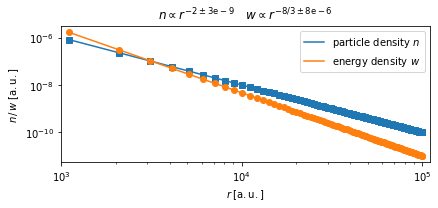

In [5]:
Rmean = np.array(groups.R.mean())
Etot = np.array(groups.E.sum())
n = Rmean**-2.
u = Etot*Rmean**-2.

popt1, cov1 = curve_fit(fit, np.log(Rmean), np.log(n))
popt2, cov2 = curve_fit(fit, np.log(Rmean), np.log(u))

print (r"The resulting power law indices for n/w \propto r^delta")
print (r"number density: delta={} \pm {}".format(popt1[0], np.sqrt(np.diag(cov1))[0]))
print (u"energy density: delta={} \pm {}".format(popt2[0], np.sqrt(np.diag(cov2))[0]))

plt.figure(figsize=(6.2, 3))
plt.plot(Rmean, n, marker='s', linewidth=0., label=None, color=colors[0])
plt.plot(np.array(Rmean), np.array(Rmean)**popt1[0]*np.exp(popt1[1]),
         label=r'particle density $n$', color=colors[0])
plt.plot(Rmean, u, marker='o', linewidth=0., color=colors[1])
plt.plot(np.array(Rmean), np.array(Rmean)**popt2[0]*np.exp(popt2[1]),
         label=r'energy density $w$', color=colors[1])

s = r'$n\propto r^{-2\pm\mathrm{3e-9}}$'+r'$\quad w\propto r^{-8/3\pm\mathrm{8e-6}}$'
plt.title(s)
plt.loglog()
plt.xlim(1e3, 1.1e5)
plt.legend()
plt.xlabel(r'$r\;[\mathrm{a.u.}]$')
plt.ylabel(r'$n\,/\,w\;[\mathrm{a.u.}]$')
plt.tight_layout()

#plt.show()

${\mathrm{\bf Fig 1:}}$ The number and energy density follow nicely the thermodynamical expectation of an ideal expanding gas.